In [ ]:
import itertools
import os
import zipfile
import csv
import textwrap
import time

from difflib import SequenceMatcher
from pprint import pprint
from collections import Counter

import spacy
import numpy
import pandas
import umap

from headless import load_pages
from scipy.spatial import KDTree
from pyhash import city_64

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import magma

output_notebook()

In [ ]:
en_nlp = spacy.load('en_core_web_lg', disable=['tagger', 'parser', 'ner'])

In [ ]:
N_BANDS = 50

def htid_url(htid):
    htid = htid.replace('+', ':').replace('=', '/')
    return 'https://babel.hathitrust.org/cgi/pt?id={}'.format(htid)

def path_to_htid(path):
    htid = os.path.split(path)[-1]
    htid = os.path.splitext(htid)[0]
    return htid.replace('+', ':').replace('=', '/')

def volume_paths(path):
    """List all zip files and subfolders in the given folder."""
    files = (os.path.join(path, f) for f in sorted(os.listdir(path)))
    return [f for f in files if os.path.isdir(f) or f.endswith('.zip')]

def numpy_paths(path):
    """List all numpy files in the given folder."""
    files = (os.path.join(path, f) for f in sorted(os.listdir(path)))
    return [f for f in files if f.endswith('.npy')]

# There are surely faster ways to tokenize, look up word vectors, 
# and build text vector arrays. But the quality of spacy tokenization
# is higher, and the extra overhead of slow Python loops only winds
# up adding 30-50% more time. The combination of flexibility and 
# high quality tokenization is worth the extra time.
class VectorTable():
    def __init__(self, spacy_model=None, ndims=300):
        self._table = {}
        self._doc_count = Counter()
        
        if spacy_model is None:
            self._vec_table = self._srp_vec_table
        else:
            self._spacy_strings = spacy_model.vocab.strings
            self._spacy_vectors = spacy_model.vocab.vectors
            self._vec_table = self._sp_vec_table
        
        self.ndims = ndims
    
    def __getitem__(self, keys):
        if isinstance(keys, str):
            keys = [keys]
        elif not isinstance(keys, list):
            keys = list(keys)
        
        # Create a one-use lookup table for all keys.
        # This represents a decent trade-off between
        # speed, memory usage, and flexibility.
        table = self._vec_table(keys)
        
        # To save memory and a bit of speed, the table
        # only contains indices underlying vector tables.
        # The data is copied only once, directly into the
        # new array.
        result = numpy.empty((len(keys), self.ndims))
        for i, k in enumerate(keys):
            sub_index, sub_table = table[k]
            result[i] = sub_table[sub_index]
        return result
    
    def _sp_vec_table(self, keys):
        keys = set(keys)
        keys_ids = [(k, self._spacy_strings[k]) for k in keys
                    if k in self._spacy_strings]
        table = {k: (i, self._spacy_vectors) for k, i in keys_ids
                 if i in self._spacy_vectors}
        missing = keys - table.keys()
        table.update(self._srp_vec_table(missing))
        return table

    def _srp_vec_table(self, keys):
        keys = list(set(keys))
        srp = self.srp_matrix(keys, self.ndims)
        return {k: (i, srp) for i, k in enumerate(keys)}
    
    # This is a quick-and-dirty implementation of what Ben Schmidt calls
    # "Stable Random Projection." (Errors are mine, not his!)
    @classmethod
    def srp_matrix(cls, words, ndims, _hashfunc=city_64(0)):
        multiplier = (ndims - 1) // 64 + 1
        hashes = [
            list(map(_hashfunc, ['{}_{}'.format(w, i) for i in range(multiplier)]))
            for w in words
        ]

        # Given a `multipier` value of 5, `hashes` is really a Vx5
        # array of 64-byte integers, where V is the vocabulary size
        # and 

        hash_arr = numpy.array(hashes, dtype=numpy.uint64)

        # But we could also think of it as an array of bytes,
        # where every word is represented by 40 bytes...

        hash_arr = hash_arr.view(dtype=numpy.uint8)

        # ...or even as an array of bits, where every word is represented
        # by 320 bits...

        hash_arr = numpy.unpackbits(hash_arr.ravel()).reshape(-1, 64 * multiplier)

        return (hash_arr.astype(numpy.float64) * 2 - 1)[:, :ndims]
    
def load_one_sp_embedding(volume_path, nlp=en_nlp, vec=VectorTable(spacy_model=en_nlp)):
    """Parse the text of one volume and extract word vectors."""
    sp_text = nlp.pipe(load_pages(volume_path))
    return vec[[tok.lower_ for doc in sp_text for tok in doc if not tok.is_space]]

def load_one_srp_embedding(volume_path, nlp=en_nlp, vec=VectorTable()):
    """Parse the text of one volume and extract word vectors."""
    sp_text = nlp.pipe(load_pages(volume_path))
    return vec[[tok.lower_ for doc in sp_text for tok in doc if not tok.is_space]]
                       
def piecewise_avg(vec, n_groups):
    """Divide a vector into pieces and return the average for each."""
    size = len(vec) / n_groups
    ends = []
    for i in range(1, n_groups + 1):
        ends.append(int(size * i))
    ends[-1] = len(vec)
    
    sums = []
    start = 0
    for end in ends:
        sums.append(vec[start:end].sum() / (end - start))
        start = end
        
    return numpy.array(sums)
        
def embedding_fft(sp_embedding, n_bands=N_BANDS):
    """
    Perform a Fourier transform on all the dimensions of an
    array of word embeddings extracted from a document. 
    `sp_embedding` is assumed to be an array with a row
    for each document, and a column for each dimension of 
    the underlying word embedding vector model.
    """
    fft_cols = []
    n_groups = 1
    while n_groups < n_bands * 10:
        n_groups *= 2
        
    for col in range(sp_embedding.shape[1]):
        vec = sp_embedding[:, col]
        vec = piecewise_avg(vec, n_groups)
        fft = numpy.fft.rfft(vec)
        fft_cols.append(fft[:n_bands])
    
    return numpy.array(fft_cols)

def flatten_fft(emb_fft, start=0, end=None, drop_zero_imag=False):
    """Reshape an fft array into a single vector."""
    complex_vec = numpy.array(emb_fft)[:, start:end].reshape(-1)
    
    # Check to see if all imaginary values are zero, and if so only include real
    if drop_zero_imag and complex_vec.imag.ravel().sum() == 0:
        return complex_vec.real
    else:
        return numpy.array([x for r_i in zip(complex_vec.real, complex_vec.imag)
                            for x in r_i])

def unflatten_vec(doc_vector):
    """Turn a document vector back into an fft array."""
    array = doc_vector.reshape(300, -1)  # This hard-codes values that should be parameters.
    real = array[:, ::2]
    imag = array[:, 1::2]
    return real + imag * 1j

def slice_vec_bands(doc_vectors, start=0, end=None):
    return numpy.array([flatten_fft(unflatten_vec(dv), start, end, drop_zero_imag=True)
                        for dv in doc_vectors])
    
def test_fft_reshape(volume_path, srp=False):
    """A test of vector-array conversion routines."""
    assert _test_fft_reshape_one(volume_path, srp)

def _test_fft_reshape_one(folder, srp):
    if srp:
        emb = load_one_srp_embedding(folder)
    else:
        emb = load_one_sp_embedding(folder)
    
    fft_orig = embedding_fft(emb)
    
    fft_complex = unflatten_vec(flatten_fft(fft_orig))
    return (fft_orig == fft_complex).all()

def save_embedding_ffts(source_path, dest_path=None, srp=False):
    dest_path = source_path if dest_path is None else dest_path
    vol_paths = volume_paths(source_path)
    new_paths = [os.path.split(vp)[-1] for vp in vol_paths]
    new_paths = [vp if not vp.endswith('.zip') else vp[:-4] for vp in new_paths]
    new_paths = [os.path.join(dest_path, vp) for vp in new_paths]
    
    if srp:
        load_emb = load_one_srp_embedding
    else:
        load_emb = load_one_sp_embedding

    for vp, np in zip(vol_paths, new_paths):
        if not os.path.exists(np + '.npy'):
            numpy.save(np, embedding_fft(load_emb(vp)))  
    
def load_embedding_fft_array(path, start=0, end=None, 
                             reload=False, htid_test=None, _cache={}):
    if (reload or not _cache or _cache['start'] != start or 
                _cache['end'] != end or htid_test is not None):
        if htid_test is not None:
            assert [path_to_htid(p) for p in numpy_paths(path)] == list(htid_test)
        _cache['start'] = start
        _cache['end'] = end
        _cache['data'] = numpy.array([flatten_fft(numpy.load(f), start, end) 
                                      for f in numpy_paths(path)])  
    return _cache['data']

# def load_embedding_fft_metadata(metadata_path, fft_path, csv_delim='\t', htid_col='htid'):
def load_metadata(metadata_path, fft_path, csv_delim='\t', htid_col='htid'):
    ids = [path_to_htid(p)
           for p in numpy_paths(fft_path)]
    metadata = (pandas
                .read_csv(metadata_path, delimiter=csv_delim)
                .drop_duplicates(htid_col)
                .set_index(htid_col))
    return metadata.reindex(ids, fill_value='[metadata missing]')

def load_fft_metadata(fft_path, metadata_path, start=0, end=None, reload=False,
                      csv_delim='\t', htid_col='htid'):
    metadata = load_metadata(metadata_path, fft_path, csv_delim, htid_col)
    fft_arr = load_embedding_fft_array(fft_path, start, end, reload, metadata.index)
    return fft_arr, metadata

def deduplicator(data, **umap_kwargs):
    data_umap = umap.UMAP(**umap_kwargs).fit_transform(data)
    data_kd = KDTree(data_umap)
    def deduplicate(distance):
        pairs = data_kd.query_pairs(distance)
        return set(frozenset(p) for p in pairs)
    return deduplicate

def umap_concat(data, **umap_kwargs):
    data_tiles = []
    for i in range(5):
        data_i = slice_vec_bands(data, start=i, end=i + 1)
        data_tiles.append(umap.UMAP(**umap_kwargs).fit_transform(data))
    data_concat = numpy.empty((data_tiles[0].shape[0], sum(dt.shape[1] for dt in data_tiles)))
    start_col = 0
    for dt in data_tiles:
        end_col = start_col + dt.shape[1]
        data[:, start_col:end_col] = dt
        start_col = end_col
        
    return data_concat

def string_similarity(a, b):
    return SequenceMatcher(a=a, b=b).ratio()

def show_dataset(folder, n=10):
    volumes = volume_paths(folder)
    for v in volumes:
        print(load_pages(v)[0][0:500])

def show_umap(data, n_neighbors=20, min_dist=0.001, metric='euclidean'):
    um = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    vis = um.fit_transform(data)
    plt.gca().axis('equal')
    plt.scatter(vis[:, 0], 
                vis[:, 1], 
                c=[i / len(vis) for i in range(len(vis))],
                cmap='plasma')
    plt.show()

def umap_color(metadata, color_field, n_colors, dtype=None, palette=magma):
    palette = palette(n_colors)
    if color_field is None:
        return [palette[n_colors // 2]] * len(metadata)
    
    if dtype is None:
        dtype = type(metadata[color_field][0])
    field = [f if isinstance(f, dtype) else dtype() 
             for f in metadata[color_field]]
    n_colors = n_colors if len(set(field)) >= n_colors else len(set(field))
    field_rank = {f: i / len(field) for i, f in enumerate(sorted(field))}
    return [palette[int(field_rank[f] * n_colors)] for f in field]

def show_umap_bokeh(data, metadata, color_field=None, n_neighbors=20, min_dist=0.001, metric='euclidean'):
    um = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    vis = um.fit_transform(data)
    color = umap_color(metadata, color_field, 20, dtype=int)
    scatter_data = pandas.DataFrame({'umap_1': vis[:, 0], 
                                     'umap_2': vis[:, 1],
                                     'color': color,
                                     'htid': list(metadata.index),
                                     'title': ['<br>'.join(textwrap.wrap(t)) 
                                               for t in metadata['title']],
                                     'author': list(metadata['author']),
                                     'pub_date': list(metadata['pub_date'])
    })
    
    plot_figure = figure(
        title=('UMAP Projection of Phasor vectors for ~1000 '
               'random HathiTrust volumes (colored by {})'.format(color_field)),
        plot_width=800,
        plot_height=800,
        tools=('pan, wheel_zoom, reset')
    )

    plot_figure.add_tools(HoverTool(
        tooltips=("<div><span style='font-size: 10px'>@htid{safe}</span></div>"
                  "<div><span style='font-size: 10px'>@author{safe}</span></div>"
                  "<div><span style='font-size: 10px'>@title{safe}</span></div>"
                  "<div><span style='font-size: 10px'>@pub_date{safe}</span></div>"
        )
    ))

    plot_figure.circle(
        'umap_1',
        'umap_2',
        color='color',
        source=scatter_data,
    )

    show(plot_figure)


In [ ]:
secure_paths = ('/media/secure_volume/workset/orig',
                '/media/secure_volume/workset/fft_npy',
                '/media/secure_volume/workset/srp_fft_npy',
                '../fiction-rand-penn-1072.tsv')
test_paths = ('../ht-open-test-data/gov_docs/',
              '../ht-open-test-data/gov_docs_fft',
              '../ht-open-test-data/gov_docs_srp_fft',
              '../ht-open-test-data/gov_docs_fakemeta.csv')

(path_to_volumes, 
 path_to_fft, 
 path_to_srp_fft, 
 path_to_meta) = test_paths

In [ ]:
for test_path in volume_paths(path_to_volumes)[:3]:
    print('testing with {}'.format(test_path))
    try:
        test_fft_reshape(test_path, srp=False)
    except Exception as e:
        print('skipping {} -- {}: {}'.format(test_path, type(e), e))

In [7]:
save_embedding_ffts(path_to_volumes, path_to_fft, srp=False)
save_embedding_ffts(path_to_volumes, path_to_srp_fft, srp=True)

In [8]:
data, metadata = load_fft_metadata(path_to_srp_fft, path_to_meta, end=20)
show_umap_bokeh(
    slice_vec_bands(data, start=0, end=None),
    metadata,
    color_field='pub_date'
)

/Users/enderlej/.virtualenvs/th/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../.virtualenvs/th/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/enderlej/.virtualenvs/th/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../.virtualenvs/th/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/enderlej/.virtualenvs/th/lib/python3.7/site-packages/numba/compiler.py:73

In [9]:
kwargs = dict(
    n_neighbors=5, 
    n_components=10, 
    metric='euclidean'
)
dedupe_slice_full = deduplicator(slice_vec_bands(data, start=0, end=10), **kwargs)
dedupe_slices = [deduplicator(slice_vec_bands(data, start=i, end=i + 1), **kwargs)
                 for i in range(10)]


/Users/enderlej/.virtualenvs/th/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components
/Users/enderlej/.virtualenvs/th/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/Users/enderlej/.virtualenvs/th/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [10]:
radius = 0.8

pairs_boolean = dedupe_slices[0](radius)
for ds in dedupe_slices[1:]:
    pairs_boolean &= ds(radius)

pairs_single = dedupe_slices[0](radius)
pairs_full = dedupe_slice_full(radius)
print("Number of candidates found by each test")
print()
print("Boolean test:     ", len(pairs_boolean))
print("Single-band test: ", len(pairs_single))
print("Full-band test:   ", len(pairs_full))

Number of candidates found by each test

Boolean test:      119
Single-band test:  10694
Full-band test:    14946


In [11]:
likely_true_positives_boolean = set(
    frozenset((a, b)) for a, b in pairs_boolean
    if string_similarity(metadata['title'][a], metadata['title'][b]) >= 0.95
)
likely_true_positives_single = set(
    frozenset((a, b)) for a, b in pairs_single
    if string_similarity(metadata['title'][a], metadata['title'][b]) >= 0.95
)
likely_true_positives_full = set(
    frozenset((a, b)) for a, b in pairs_full
    if string_similarity(metadata['title'][a], metadata['title'][b]) >= 0.95
)

print("Number of likely duplicates (based on title) found by each test")
print()
print("Boolean test:     ", len(likely_true_positives_boolean))
print("Single-band test: ", len(likely_true_positives_single))
print("Full-band test:   ", len(likely_true_positives_full))
print()
print("Number of near-certain duplicates missed by single test, caught by boolean test:")
print(len(likely_true_positives_boolean - likely_true_positives_single))
print()
print("Number of near-certain duplicates missed by boolean test, caught by single test:")
print(len(likely_true_positives_single - likely_true_positives_boolean))
print()
print("NOTE: A number of false positives may still appear in these counts because "
      "different volumes from multi-volume works may have the same title even "
      "though they do not contain the same content. This accounts for many of the "
      "matches captured by the single-band but not by the boolean test. The "
      "single-band test captures the broad semantic similarity between volumes of "
      "the same work, but can't make fine-grained distinctions between individual "
      "volumes of the work.")

Number of likely duplicates (based on title) found by each test

Boolean test:      117
Single-band test:  9412
Full-band test:    13339

Number of near-certain duplicates missed by single test, caught by boolean test:
0

Number of near-certain duplicates missed by boolean test, caught by single test:
9295

NOTE: A number of false positives may still appear in these counts because different volumes from multi-volume works may have the same title even though they do not contain the same content. This accounts for many of the matches captured by the single-band but not by the boolean test. The single-band test captures the broad semantic similarity between volumes of the same work, but can't make fine-grained distinctions between individual volumes of the work.


In [12]:
pairs = list(pairs_boolean)

In [13]:
distances = [((data[x] - data[y]) ** 2).sum() ** 0.5 for x, y in pairs]
order = sorted(range(len(distances)), key=distances.__getitem__)
pairs_sorted = [pairs[i] for i in order]
distances = [distances[i] for i in order]

for a, b in pairs_sorted:
    a_id = metadata.index[a]
    b_id = metadata.index[b]
    a_ti = metadata['title'][a]
    b_ti = metadata['title'][b]
    a_au = metadata['author'][a]
    b_au = metadata['author'][b]
    d = ((data[a] - data[b]) ** 2).sum() ** 0.5
    s = string_similarity(a_ti, b_ti)

    print()
    print()
    print('Raw Phasor Embedding Distance: ', d)
    print(htid_url(a_id))
    print(a_au, " ~~ ", a_ti)
    print(htid_url(b_id))
    print(b_au, " ~~ ", b_ti)
    print()
    print('------')
    



Raw Phasor Embedding Distance:  27.012945184204078
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t2k64cs40
Fake Author  ~~  Fake Title
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t3708mm67
Fake Author  ~~  Fake Title

------


Raw Phasor Embedding Distance:  28.107067031878092
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t9t15jw5n
Fake Author  ~~  Fake Title
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/fk2p55dk5g
Fake Author  ~~  Fake Title

------


Raw Phasor Embedding Distance:  32.666319015087794
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t21c2jz68
Fake Author  ~~  Fake Title
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t1sf2xd1g
Fake Author  ~~  Fake Title

------


Raw Phasor Embedding Distance:  33.99481394819938
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t73v04g9j
Fake Author  ~~  Fake Title
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t8mc92t2b
Fake Author  ~~  Fake Title

------


Raw Phasor Embedding Distance:  34.24497696335777




Raw Phasor Embedding Distance:  362.5290964059538
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t9t15kr2t
Fake Author  ~~  Fake Title
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t00z7283z
Fake Author  ~~  Fake Title

------


Raw Phasor Embedding Distance:  363.40460469967394
https://babel.hathitrust.org/cgi/pt?id=abd4813,0002,001
[metadata missing]  ~~  [metadata missing]
https://babel.hathitrust.org/cgi/pt?id=abd4709,0011,001
[metadata missing]  ~~  [metadata missing]

------


Raw Phasor Embedding Distance:  494.0863456111655
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t32231z5f
Fake Author  ~~  Fake Title
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t6445tb3t
Fake Author  ~~  Fake Title

------


Raw Phasor Embedding Distance:  501.01324487105313
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t6tx3ss1n
Fake Author  ~~  Fake Title
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t82j6fd81
Fake Author  ~~  Fake Title

------


Raw Phasor Embedding Distance:

In [14]:
data_freq_array = [unflatten_vec(r) / len(data) for r in data]  # 300 rows, 20 cols in each array, ~1000 arrays

data_freq_mean = data_freq_array[0]
for dfa in data_freq_array[1:]:
    data_freq_mean += dfa

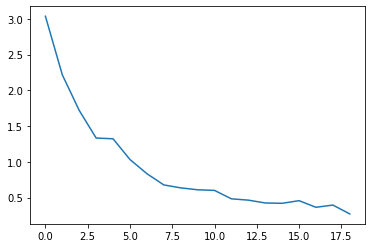

In [15]:
power_a = data_freq_mean[:, 1:].real
power_b = data_freq_mean[:, 1:].imag
power = (power_a * power_a + power_b * power_b) ** 0.5

mean_power = power.sum(axis=0) / 300
plt.plot(mean_power)

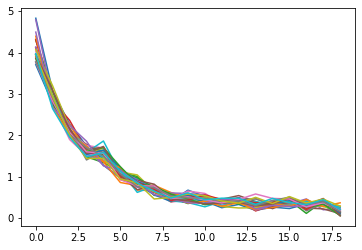

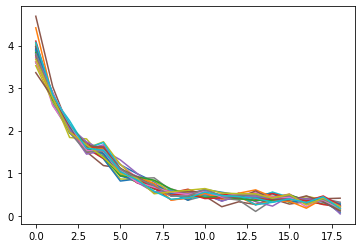

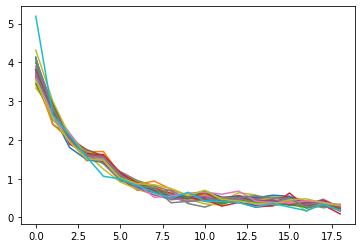

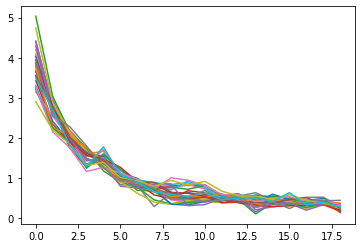

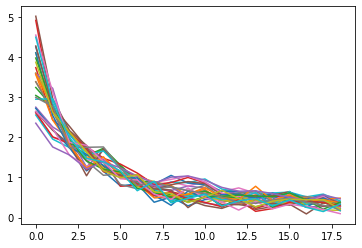

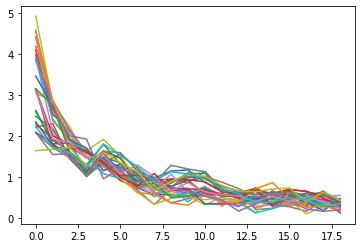

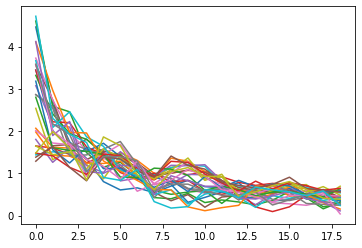

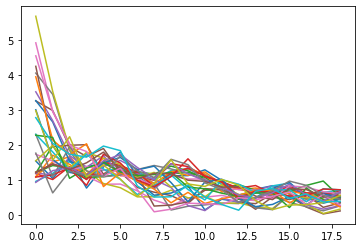

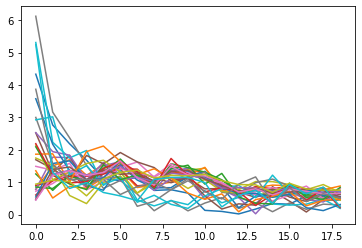

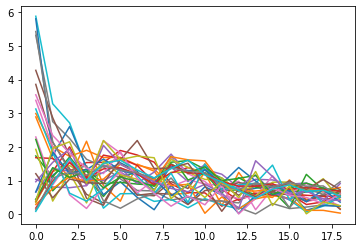

In [16]:
scaled_mean = mean_power / mean_power.mean()
scaled_power = power / power.mean(axis=0)
# scaled_rel_diff = []

scaled_diffs = numpy.array([(((scaled_power[i] - scaled_mean) / scaled_power[i]) ** 2).sum()
                            for i in range(len(power))])

scaled_diffs_argsort = scaled_diffs.argsort()

for chunk in range(10):
    for i in range(chunk * 30, chunk * 30 + 30):
        plt.plot(power[scaled_diffs_argsort[i]] / 
                 power[scaled_diffs_argsort[i]].mean())
    plt.show()




In [24]:
unstable_vec = numpy.zeros(len(scaled_diffs), dtype=numpy.float64)
unstable_vec[scaled_diffs_argsort] = (numpy.arange(len(scaled_diffs)) / len(scaled_diffs)) > 0.99
unstable_vec = unstable_vec.reshape(1, -1)

stable_vec = numpy.zeros(len(scaled_diffs), dtype=numpy.float64)
stable_vec[scaled_diffs_argsort] = (numpy.arange(len(scaled_diffs)) / len(scaled_diffs)) < 0.01
stable_vec = stable_vec.reshape(1, -1)

def get_similar(vec, comp_word):
    vec = vec + en_nlp.vocab.vectors[en_nlp.vocab.strings[comp_word]]
    t_id = en_nlp.vocab.vectors.most_similar(vec)[0][0]
    return en_nlp.vocab.strings[t_id]

# get_similar(unstable_vec, "lost")